In [ ]:
import pandas as pd
import requests
import csv
import re

r = requests.get('https://www.jobfeed.nl/api/v3/search?_fields=posting_id,job_title,full_text&date__range=now-2M__now&_limit=5000&job_title=senior|sr|medior|junior|jr',
                 auth=('ANONYMOUS', 'ANONYMOUS'))

results = pd.DataFrame(r.json()['results'])

def determine_seniority(title):
    seniority = ''
    if re.search(r'\b(senior|sr)\b', title, re.IGNORECASE):
        seniority = 'Senior'
    elif re.search(r'\b(medior)\b', title, re.IGNORECASE):
        seniority = 'Medior'
    elif re.search(r'\b(junior|jr)\b', title, re.IGNORECASE):
        seniority = 'Junior'
    return seniority

results['seniority_level'] = results['job_title'].apply(determine_seniority)

results[['posting_id', 'job_title', 'full_text', 'seniority_level']] \
    .to_csv('data/seniority-nl.csv', index=False, header=True, quoting=csv.QUOTE_ALL)

In [1]:
#import numpy as np
#np.random.shuffle(df.values)
#df = df.drop_duplicates(subset=['posting_id'])

In [2]:
#df.to_csv('data/seniority-nl.csv', index=False)

In [3]:
#from langdetect import detect
#df['lang'] = df['full_text'].apply(detect)

In [4]:
#sns.countplot(x=df['lang'])

In [5]:
#df = df[df.lang == 'nl']

In [1]:
import pandas as pd

df = pd.read_csv('data/seniority-nl.csv', index_col=None)

In [2]:
df.head(n=25)

,posting_id,job_title,full_text,seniority_level,lang
0,efaeaed6e438415c8f38171d25716f32,Senior Projectleider Bouw,Senior Projectleider Bouw\n\n Werkgever: Ce...,Senior,nl
1,018a0a712c444f38827a796cb8c4c72b,Gezocht: Medior Backend Developer /Uur,Gezocht: Medior Backend Developer /Uur\n\n ...,Medior,nl
2,654c5d51de3b44e2876d2fa88c20c418,Senior Schadebehandelaar Volmacht,* Zoekresultaat\n * Vacature\n\n Senior Sc...,Senior,nl
3,f2c5aed1e11c46ebb6c818b3f7b33235,Junior/medior software developer in het midden...,no.logo.alt\n no.logo.alt\n\n Junior/medio...,Medior,nl
4,58a1a5ffb56b48cdaedd9e9045e3a011,Medior belastingadviseur - (inter)nationale MK...,Medior belastingadviseur - (inter)nationale ...,Medior,nl
5,02d1517026dd44ffb2b688bed296138e,Junior Werkvoorbereider,Junior Werkvoorbereider\n\n Vacature omschr...,Junior,nl
6,94461eb87e5247158115c4e54eb1ca8d,Medior Consultant Microsoft s CRM,Medior Consultant Microsoft s CRM\n\n Job i...,Medior,nl
7,2ef2f40a028144f999f372cff76c4c71,Junior BRP Specialist,« Ga terug Print\n\n Junior BRP Specialist\...,Junior,nl
8,529ff3befb224338a6d1dd70f4ebd3be,Senior Payroll Officer - Amsterdam,Senior Payroll Officer - Amsterdam\n\n Wat ...,Senior,nl
9,3c1a9a405e66467da33027c8d36ef2a6,Medior Tester / geautomatiseerd testen / 2500 ...,Medior Tester / geautomatiseerd testen / 250...,Medior,nl


In [3]:
df.shape

(28026, 5)

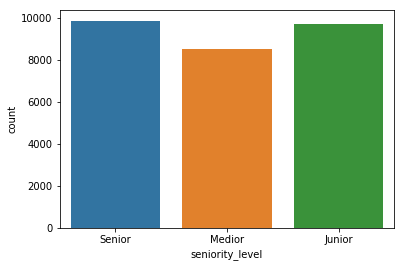

In [4]:
%matplotlib inline

import seaborn as sns

sns.countplot(x=df['seniority_level'])

In [5]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, stem_text, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, strip_non_alphanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from unicodedata import normalize

my_filters = [
    lambda x: x.lower(), strip_punctuation, strip_non_alphanum,
    strip_multiple_whitespaces, remove_stopwords
]

def my_tokenizer(s):
    return preprocess_string(s, filters=my_filters)

stop_words = ['junior', 'medior', 'senior']
    
vect = CountVectorizer(min_df=50, max_df=0.2, analyzer='word', tokenizer=my_tokenizer, ngram_range=(1, 3),
                       stop_words=stop_words)

le = LabelEncoder()

X = vect.fit_transform(df['full_text'])
y = le.fit_transform(df['seniority_level'])

In [6]:
X.shape

(28026, 48717)

In [7]:
y.shape

(28026,)

In [8]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Normalizer

classifiers = [
    MultinomialNB(),
    
    LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial'),
    
    #LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial', class_weight='balanced'),
    
    make_pipeline(
        SelectKBest(f_classif, 1000),
        MultinomialNB()
    ),
    
    make_pipeline(
        SelectKBest(f_classif, 1000),
        LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
    ),
    
    make_pipeline(
        TruncatedSVD(n_components=1500),
        LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
    ),
    
    make_pipeline(
        SelectKBest(f_classif, 1000),
        Normalizer(),
        MLPClassifier(hidden_layer_sizes=(8,), max_iter=1000)
    )
]

for clf in classifiers:
    accs = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='accuracy')
    f1s = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='f1_macro')
    lls = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='neg_log_loss')

    print("{:>24} Accuracy: {:.2f} (+/- {:.2f}) F1: {:.2f} (+/- {:.2f}) Log loss: {:.2f} (+/- {:.2f})" \
          .format(clf.__class__.__name__, accs.mean(), accs.std(), f1s.mean(), f1s.std(), lls.mean(), lls.std()))

           MultinomialNB Accuracy: 0.65 (+/- 0.01) F1: 0.64 (+/- 0.01) Log loss: -9.87 (+/- 0.06)
      LogisticRegression Accuracy: 0.79 (+/- 0.00) F1: 0.79 (+/- 0.00) Log loss: -0.84 (+/- 0.01)
                Pipeline Accuracy: 0.58 (+/- 0.01) F1: 0.55 (+/- 0.00) Log loss: -4.17 (+/- 0.20)
                Pipeline Accuracy: 0.67 (+/- 0.00) F1: 0.66 (+/- 0.00) Log loss: -0.73 (+/- 0.01)
                Pipeline Accuracy: 0.73 (+/- 0.00) F1: 0.72 (+/- 0.00) Log loss: -0.68 (+/- 0.01)
                Pipeline Accuracy: 0.67 (+/- 0.00) F1: 0.67 (+/- 0.00) Log loss: -0.81 (+/- 0.02)


In [9]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

#clf = MultinomialNB()
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.85      0.84      0.85      1937
      Medior       0.76      0.78      0.77      1700
      Senior       0.77      0.76      0.77      1969

   micro avg       0.79      0.79      0.79      5606
   macro avg       0.79      0.79      0.79      5606
weighted avg       0.79      0.79      0.79      5606



In [11]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype=object)

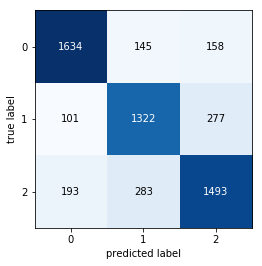

In [12]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [13]:
import numpy as np

feature_names = vect.get_feature_names()

for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: starters, hoogeveen, 2 000, vergunningverlening, onder begeleiding, startersfunctie, leergierig, 2000, leergierige, standplaats rotterdam, leren, 2 jaar, 2500, 1 jaar, enige, afgestudeerd, venlo, stage, jr, starter

Medior: 3 000, powershell, php wat wij, end php wat, overig, php wat, 2 5 jaar, backend developer, functional, 3 5, ervaring 2, developer job, projecten en, 2018, utrecht opleidingsniveau, 20 job specializations, 20 job, tot 5 jaar, 3 5 jaar, instandhouding

Senior: 7 jaar, developer end, op 24, 5000, bright, minimaal 10, ervaring als, ervaren, minimaal 7 jaar, minimaal 7, 8 jaar, handhaving, 5 000, veghel, solution, minimaal 5 jaar, 5 jaar, 10 jaar, minimaal 5, sr



In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NB_WORDS = 400000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['full_text'])

print('Found %s unique tokens.' % len(tokenizer.word_index))

Using TensorFlow backend.


Found 124231 unique tokens.


In [15]:
sequences = tokenizer.texts_to_sequences(df['full_text'])
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [51]:
from keras.utils import to_categorical

y_keras = to_categorical(y)

In [19]:
#sequences[0]

In [18]:
#tokenizer.__dict__

In [52]:
X_train, X_val, y_train, y_val = train_test_split(sequences, y_keras, test_size=0.1, shuffle=True)

In [10]:
from gensim.models import KeyedVectors

vectors = KeyedVectors.load_word2vec_format('/home/dehling/Downloads/glove.6B.100d.txt', binary=False)

In [18]:
import numpy as np

embedding_matrix = np.random.normal(0.0, 1.0, (len(tokenizer.word_index) + 1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in vectors:
        embedding_matrix[i] = vectors.get_vector(word)

In [65]:
from keras.models import Sequential
from keras.layers import Input, Embedding, Dropout, Dense, GRU, BatchNormalization

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1,
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(GRU(32))
model.add(BatchNormalization())
#model.add(Dropout(rate=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          12423200  
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                12768     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 12,436,195
Trainable params: 12,931
Non-trainable params: 12,423,264
_________________________________________________________________


In [68]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, verbose=True)

Train on 25223 samples, validate on 2803 samples
Epoch 1/10
25223/25223 [==============================] - 7s 273us/step - loss: 0.6752 - acc: 0.6783 - val_loss: 0.7928 - val_acc: 0.6336
Epoch 2/10
25223/25223 [==============================] - 7s 272us/step - loss: 0.6609 - acc: 0.6868 - val_loss: 0.7881 - val_acc: 0.6418
Epoch 3/10
25223/25223 [==============================] - 7s 274us/step - loss: 0.6503 - acc: 0.6909 - val_loss: 0.8108 - val_acc: 0.6397
Epoch 4/10
25223/25223 [==============================] - 7s 277us/step - loss: 0.6345 - acc: 0.6987 - val_loss: 0.8053 - val_acc: 0.6390
Epoch 5/10
25223/25223 [==============================] - 7s 273us/step - loss: 0.6223 - acc: 0.7056 - val_loss: 0.8032 - val_acc: 0.6375
Epoch 6/10
25223/25223 [==============================] - 7s 271us/step - loss: 0.6077 - acc: 0.7153 - val_loss: 0.8126 - val_acc: 0.6347
Epoch 7/10
25223/25223 [==============================] - 7s 277us/step - loss: 0.5951 - acc: 0.7213 - val_loss: 0.8147 - v

In [69]:
matrix = confusion_matrix(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))

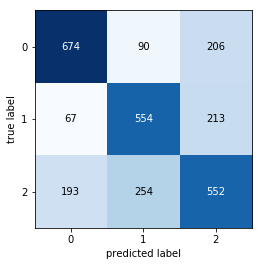

In [70]:
_ = plot_confusion_matrix(matrix)